In [8]:
# Importing the necessary libraries for AI2-THOR to run

!pip install --upgrade ai2thor ai2thor-colab &> /dev/null
import ai2thor
import ai2thor_colab
import time
import math
from typing import Dict, List

from ai2thor.controller import Controller
from ai2thor_colab import (
    plot_frames,
    show_objects_table,
    side_by_side,
    overlay,
    show_video
)

# Class for controlling robot navigation. This is where we will have all the navigation commands.
# This has NOT yet got the LLM connected, but merely a set of tools to move the robot and to interact
# with the simulation environment.
class RobotNavigationControl:
    is_DEBUG = False

    # Starts server
    def start_ai2_thor(self):
        ai2thor_colab.start_xserver()
        "AI2-THOR Version: " + ai2thor.__version__

    # Initialises controller
    def initialise_controller(self):
        self.controller = Controller(
            agentMode="default",
            visibilityDistance=3, #设置机器人的可视距离为3米
            scene="FloorPlan209",
            # image modalities
            #renderDepthImage=False,
            #renderInstanceSegmentation=False,
            # camera properties
            width=400,
            height=400,
            fieldOfView=120, #设置相机的视场角度
            # step sizes
            gridSize=0.25, #设置机器人每次移动的大小
            snapToGrid=True, #设置代理在网格上移动（即，代理每次移动都会对齐到网格点上）
            #rotateStepDegrees=15,
        )

        # If debug is enabled, then print scene name and a few other things.
        if (self.is_DEBUG):
            event = self.controller.step(action="RotateRight")
            metadata = event.metadata
            print(event, event.metadata.keys()) #打印这个动作下的所有信息
            print("sceneName : " + self.controller.last_event.metadata["sceneName"]) #场景名称
            print("agent_pos : " + str(self.controller.last_event.metadata["agent"]["position"])) #机器人位置
            print("agent_rtn : " + str(self.controller.last_event.metadata["agent"]["rotation"])) #机器人旋转信息
            #print("actionReturn : " + controller.last_event.metadata["actionReturn"])

        # 添加了一个第三方摄像头。这个摄像头被放置在指定的位置和旋转角度，并设置了视场角度。
        # 这可以用于获取环境的额外视角，有助于更全面地理解和分析环境。
        event = self.controller.step(
            action="AddThirdPartyCamera",
            position=dict(x=-4.25, y=2, z=-2.5),
            rotation=dict(x=90, y=0, z=0),
            fieldOfView=120
        )
            
    # Print a table of all objects in the scene
    # 显示当前场景中所有对象的信息
    def show_all_objects(self):
        show_objects_table(self.controller.last_event.metadata['objects'])
        print(self.controller.last_event.metadata['objects'])
    
    # Rotate left by given number of degrees degrees
    def rotate_left(self, deg):
        frames = []
        for _ in range(int(deg) // 5):
            frames.append(self.controller.step(action="RotateLeft", degrees=5).frame)
            time.sleep(0.05)
        
    # Rotate right by given number of degrees degrees
    def rotate_right(self, deg):
        frames = []
        for _ in range(int(deg) // 5):
            frames.append(self.controller.step(action="RotateRight", degrees=5).frame)
            time.sleep(0.05)
        
    # Rotate right or left depending on the degree (positive degree- right, negative - left)
    # 正值表示向右旋转，负值表示向左旋转
    def rotate_by_degree(self, deg):
        if (deg < 0):
            self.rotate_left(abs(deg))
        else:
            self.rotate_right(abs(deg))
        
    # Store visible objects in the self.visible_objects collection and print them out if needed
    # 检索并返回 AI2-THOR 环境中当前可见的对象，并且根据需要将这些对象的信息打印出来。
    def get_visible_objects(self, print_objects = False):
        objects = self.controller.last_event.metadata['objects']
        visible_objects = []

        for obj in objects:
            if obj['visible']:
                if print_objects:
                    print(obj['objectType'] + " : " + str(obj['position']))
                visible_objects.append(obj)
                
        return visible_objects
        
    # Find the closest positon from the given reachable positions to the given object position using
    # Pythagorean theorem.(勾股定理)
    # 找出一组可达位置中离指定对象位置最近的位置
    # object_position: 一个字典，表示目标对象的位置。这个位置以 {x, y, z} 坐标的形式给出。
    # reachable_positions: 一个字典列表，每个字典都包含了一个可达位置的 {x, y, z} 坐标。
    # 方法的返回类型也是一个字典，代表找到的最近位置。
    def closest_position(self, object_position: Dict[str, float], 
                         reachable_positions: List[Dict[str, float]]) -> Dict[str, float]:
        out = reachable_positions[0] # 假设选取地一个位置为最短的距离
        min_distance = float('inf') # 将第一个距离设置为无穷大的距离，下面通过for循环迭代，找到最短的距离
        for pos in reachable_positions:
            # NOTE: y is the vertical direction, so only care about the x/z ground positions
            # 通过x，y计算机器人与可到达物体的距离
            dist = sum([(pos[key] - object_position[key]) ** 2 for key in ["x", "z"]])
            # 找到最短的距离
            if dist < min_distance:
                min_distance = dist
                out = pos
        return out # 返回的同样是一个字典类型

    # Finds the given object name in the given collection of objects and if found, returns the actual object
    # 目的是在给定的对象集合中查找一个特定名称的对象，并在找到后返回这个对象
    def validate_object_in_collection(self, obj_name, obj_collection): 
        # 提取的名称被放入一个列表中，并通过 sorted 函数进行排序。这可能是为了方便查找或改善性能
        obj_names = sorted([obj["objectType"] for obj in obj_collection])
        
        try:
            assert obj_name in obj_names
        except AssertionError:
            print(obj_name + " is not visible!!!!!!!!!!!!!!!!")
            return None
        # 查找并返回目标对象
        # 这是一个生成器表达式，用于遍历 obj_collection 中的每个对象 obj。
        # 对于每个对象 obj，表达式检查该对象的 "objectType" 属性是否等于 obj_name。
        obj_of_interest = next(obj for obj in obj_collection if obj["objectType"] == obj_name)
        return obj_of_interest
    
    # Navigate to object defined by the name in the input
    # 导航至一个指定名称的对象
    def navigate_to_object(self, obj_name):
        #plot_frames(self.controller.last_event)
        # 找到在视野范围内是否有这个可以导航的对象
        obj_navigate_to = self.validate_object_in_collection(obj_name, self.get_visible_objects())
        
        # Can't navigate to an unknown object
        if (obj_navigate_to is None):
            return
        
        # 使用控制器执行 GetReachablePositions 动作，获取当前环境中代理（机器人）可以到达的所有位置。
        reachable_positions = self.controller.step(action="GetReachablePositions").metadata["actionReturn"]
        
        # 找到可以导航对象的具体位置
        pos_navigate_to = self.closest_position(obj_navigate_to['position'], reachable_positions)
        
        #print(pos_navigate_to)
        # Teleport 动作常用于瞬间移动代理到指定位置
        self.controller.step(action="Teleport", **pos_navigate_to)
        #plot_frames(self.controller.last_event)
        
    # Print pose of the object defined by the name in the input
    # 打印指定名称对象的位置和旋转信息（即姿态）
    def print_pose_of_object(self, obj_name):
        # 找到想要找的对象
        obj_of_interest = self.validate_object_in_collection(obj_name, self.controller.last_event.metadata['objects'])
        
        # Unknown object
        if (obj_of_interest is None):
            return
        
        print("position of " + obj_name + " : " + str(obj_of_interest["position"]))
        print("rotation of " + obj_name + " : " + str(obj_of_interest["rotation"]))
        
    # Print current pose of robot
    # 打印当前机器人的位置和旋转信息
    def print_current_pose_of_robot(self):
        print("agent_pos : " + str(self.controller.last_event.metadata["agent"]["position"]))
        print("agent_rtn : " + str(self.controller.last_event.metadata["agent"]["rotation"]))
        
    # Calculate angle from the target that we need to rotate by to face the target
    def get_angle_offset_from_target(self, obj_name):
        # 找到想要找的对象
        obj_of_interest = self.validate_object_in_collection(obj_name, self.controller.last_event.metadata['objects'])
        
        # Unknown object
        if (obj_of_interest is None):
            return None
        
        # 获取机器人当前的位置
        robot_position = self.controller.last_event.metadata["agent"]["position"]
        
        # Using formula tg(alpha) = a/b to find relative angle from robot to object
        #tg_alpha = (robot_position["z"] - obj_of_interest["position"]["z"]) / (robot_position["x"] - obj_of_interest["position"]["x"])
        z_diff = (robot_position["z"] - obj_of_interest["position"]["z"])
        x_diff = (robot_position["x"] - obj_of_interest["position"]["x"])
        #print(math.degrees(math.atan2(z_diff, x_diff)))
        # 将计算得到的弧度值转换为度数，这是更常用的角度表示方式
        # 返回的是两点间连线与 x 轴正方向的夹角，其范围在 -π 到 π 之间。
        return math.degrees(math.atan2(z_diff, x_diff))
        
    # Rotate to face the selected target
    def rotate_to_face_target(self, obj_name):
        # 算从机器人当前位置到目标对象的角度偏移。这个偏移是相对于机器人当前的朝向
        angle_to_target = self.get_angle_offset_from_target(obj_name)
        
        if (angle_to_target is None):
            print(obj_name + " not visibile")
            return
        
        # 在 3D 空间中，y 轴通常代表“上”方向，所以这里的 yaw 角表示机器人在水平面上的朝向
        # 获取的是机器人当前的朝向（在 y 轴上的旋转角度），就是像人视野水平的转向
        current_robot_yaw = self.controller.last_event.metadata["agent"]["rotation"]["y"]
        
        self.rotate_by_degree(angle_to_target - current_robot_yaw)
        #print("rotating by: " + str(angle_to_target - current_robot_yaw) + " " + str(angle_to_target) + " " + str(current_robot_yaw))
        
    # Get ceiling camera image -- can try using this if you don't like the 3rd camera set up earlier.
    def get_ceiling_image(self):
        # puts the camera in the ceiling, then puts it back with the robot
        # 'ToggleMapView' 动作通常用于切换到一个从上方（比如天花板）观察场景的视图，这个视图可以提供场景的俯视图像
        event = self.controller.step('ToggleMapView')
        # 方法再次调用同样的 'ToggleMapView' 动作
        self.controller.step('ToggleMapView')
        # 第一次调用切换到天花板视图，第二次调用可能是为了将视图切换回机器人的正常视角
        # 获取切换视图后的第一帧图像，这里获取的是天花板视角的图像
        return event.frame
    

In [9]:
# 对自己创建的类进行初始化
rnc = RobotNavigationControl()
rnc.start_ai2_thor()
rnc.initialise_controller()

ArmChair : {'x': -4.334003448486328, 'y': 0.001995176076889038, 'z': -3.5289852619171143}
CoffeeTable : {'x': -2.4740657806396484, 'y': 0.0015519559383392334, 'z': -2.4894556999206543}
CreditCard : {'x': -2.2253689765930176, 'y': 0.5794721841812134, 'z': -3.0478708744049072}
Drawer : {'x': -4.022149562835693, 'y': 0.4777914583683014, 'z': -5.032012939453125}
Drawer : {'x': -4.022149085998535, 'y': 0.169514998793602, 'z': -5.0320048332214355}
Drawer : {'x': -2.981975555419922, 'y': 0.4814813733100891, 'z': -5.03201150894165}
Drawer : {'x': -2.9780020713806152, 'y': 0.16951735317707062, 'z': -5.032003402709961}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
KeyChain : {'x': -4.214433193206787, 'y': 0.3217523396015167, 'z': -3.6542670726776123}
Laptop : {'x': -2.57079815864563, 'y': 0.5791798233985901, 'z': -2.5124337673187256}
Pen : {'x': -2.829010248184204,

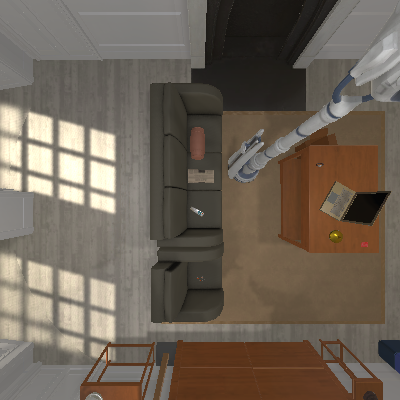

In [12]:
rnc.rotate_left(180)
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
plot_frames(ev.third_party_camera_frames[0])

agent_pos : {'x': -2.5, 'y': 0.9027014970779419, 'z': -3.5}
agent_rtn : {'x': -0.0, 'y': 180.00003051757812, 'z': 0.0}
-79.0493526032736
Book : {'x': -2.525362730026245, 'y': 0.6999013423919678, 'z': -5.124803066253662}
Drawer : {'x': -4.022149562835693, 'y': 0.4777914583683014, 'z': -5.032012939453125}
Drawer : {'x': -4.022149085998535, 'y': 0.169514998793602, 'z': -5.0320048332214355}
Drawer : {'x': -2.981975555419922, 'y': 0.4814813733100891, 'z': -5.03201150894165}
Drawer : {'x': -2.9780020713806152, 'y': 0.16951735317707062, 'z': -5.032003402709961}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
FloorLamp : {'x': -4.821146011352539, 'y': 0.00020366907119750977, 'z': -5.118946075439453}
GarbageCan : {'x': -0.969962477684021, 'y': -0.027726799249649048, 'z': -5.058005332946777}
Painting : {'x': -3.372999906539917, 'y': 1.8009999990463257, 'z': -5.392777

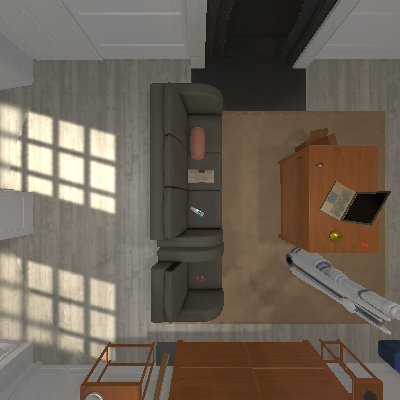

In [13]:
rnc.navigate_to_object("Vase")
rnc.print_current_pose_of_robot()
print(rnc.get_angle_offset_from_target("Vase"))
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
plot_frames(ev.third_party_camera_frames[0])

agent_pos : {'x': -2.5, 'y': 0.9027014970779419, 'z': -3.5}
agent_rtn : {'x': 0.0, 'y': 285.0000305175781, 'z': 0.0}
ArmChair : {'x': -4.334003448486328, 'y': 0.001995176076889038, 'z': -3.5289852619171143}
Drawer : {'x': -4.022149562835693, 'y': 0.4777914583683014, 'z': -5.032012939453125}
Drawer : {'x': -4.022149085998535, 'y': 0.169514998793602, 'z': -5.0320048332214355}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
FloorLamp : {'x': -4.821146011352539, 'y': 0.00020366907119750977, 'z': -5.118946075439453}
KeyChain : {'x': -4.214433193206787, 'y': 0.3217523396015167, 'z': -3.6542670726776123}
Newspaper : {'x': -4.237964630126953, 'y': 0.3441956341266632, 'z': -2.164184093475342}
Pillow : {'x': -4.282398700714111, 'y': 0.42073073983192444, 'z': -1.7359906435012817}
RemoteControl : {'x': -4.292991638183594, 'y': 0.33039507269859314, 'z': -2.6639568805694

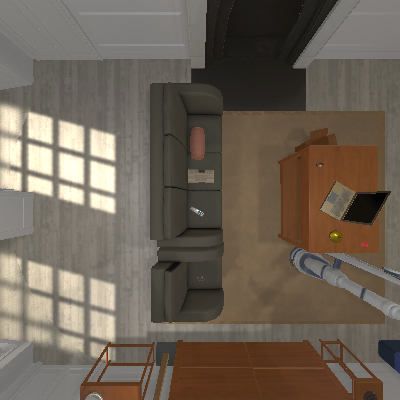

In [14]:
rnc.rotate_to_face_target("Vase")
rnc.print_current_pose_of_robot()
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
plot_frames(ev.third_party_camera_frames[0])

Book : {'x': -2.525362730026245, 'y': 0.6999013423919678, 'z': -5.124803066253662}
CoffeeTable : {'x': -2.4740657806396484, 'y': 0.0015519559383392334, 'z': -2.4894556999206543}
CreditCard : {'x': -2.2253689765930176, 'y': 0.5794721841812134, 'z': -3.0478708744049072}
Drawer : {'x': -2.981975555419922, 'y': 0.4814813733100891, 'z': -5.03201150894165}
Drawer : {'x': -2.9780020713806152, 'y': 0.16951735317707062, 'z': -5.032003402709961}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
GarbageCan : {'x': -0.969962477684021, 'y': -0.027726799249649048, 'z': -5.058005332946777}
Laptop : {'x': -2.57079815864563, 'y': 0.5791798233985901, 'z': -2.5124337673187256}
Painting : {'x': -3.372999906539917, 'y': 1.8009999990463257, 'z': -5.392777442932129}
Pen : {'x': -2.829010248184204, 'y': 0.7048501372337341, 'z': -4.962978363037109}
Shelf : {'x': -2.475966215133667, '

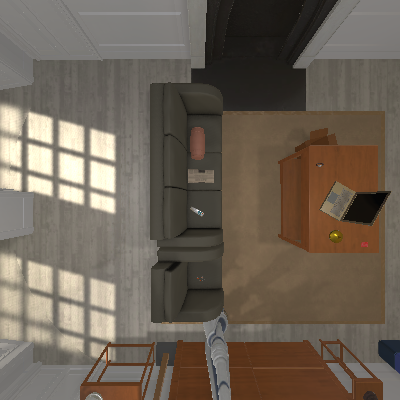

In [15]:
#aa = rnc.get_visible_objects(True)
rnc.navigate_to_object("Drawer")
rnc.rotate_to_face_target("Drawer")
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
plot_frames(ev.third_party_camera_frames[0])